In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [6]:
path_to_forcing = "../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_npp = "../../../../1_data_processing/1_1_Forcing/products/Hot_observed_npp.zarr"
path_to_obs = "../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoPym_HOT_obs_npp_opti_all_parameters_day"

In [7]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

## Loading


### Forcing


In [8]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 322kB
Dimensions:              (latitude: 1, longitude: 1, time: 1827, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-01 ... 2010-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 44kB 24.7...
    U                    (latitude, longitude, time, depth) float64 44kB -0.0...
    V                    (latitude, longitude, time, depth) float64 44kB 0.15...
    mnkc_epi             (latitude, longitude, time) float64 15kB 0.2904 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 15kB 0.8233 ... ...
    mnkc_lmeso           (latitude, longitude, time) float64 15kB 2.403 ... 1...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 15kB 0.5779 ... ...
    mnkc_umeso           (latitude, longitude, time) float64 15kB 0.79 ... 0....
    npp                  (latitude, longitude, time) float64 15kB 221.1 ... 3...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 44kB 107....
    zeu                  (latitude, longitude, time) float64 15kB 71.63 ... 7...
    zooc                 (latitude, longitude, time) float64 15kB 0.2527 ... ...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [9]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[107.43817318960242 107.62027138586784 111.3608022247511 ... 122.58406536705469 117.0609769555549 112.42833201753643]]]
Units,meter


## Observed npp


In [10]:
npp = xr.open_dataset(path_to_npp, engine="zarr")
npp = npp.sel(time=slice(TIME_START, TIME_END))
npp = npp.dropna("time", how="all")
npp = npp.resample(time="D").interpolate("linear")
npp.time.attrs["axis"] = "T"
npp.load()

<xarray.Dataset> Size: 73kB
Dimensions:        (time: 1827, latitude: 1, longitude: 1)
Coordinates:
  * latitude       (latitude) float64 8B 22.75
  * longitude      (longitude) int64 8B -158
  * time           (time) datetime64[ns] 15kB 2005-01-01 ... 2010-01-01
Data variables:
    l12            (time, latitude, longitude) float64 15kB 216.4 ... 261.5
    l12_lowess_10  (time, latitude, longitude) float64 15kB 355.5 ... 343.6
    l12_lowess_2   (time, latitude, longitude) float64 15kB 247.3 ... 267.8
    l12_lowess_5   (time, latitude, longitude) float64 15kB 315.9 ... 312.1

### Observations


In [11]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[129.6241254518878]]] [[[241.93912957042275]]] [[[226.49606461724028]]] [[[297.7116912786574]]] [[[338.10901943263667]]] [[[348.62482773763463]]] [[[414.2199967520759]]] [[[380.37086633863925]]] [[[310.58447115849805]]] [[[299.6403565698716]]] [[[286.7338167009678]]] [[[203.04283404086257]]] [[[182.27868432749716]]] [[[213.14200856879958]]] [[[158.16330671375027]]] [[[213.21478647165335]]] [[[192.88052379372309]]] [[[178.96047463029464]]] [[[192.29199558308798]]] [[[279.3417600824082]]] [[[245.83409341816906]]] [[[251.6896388460537]]] [[[321.7758900737953]]] [[[240.68806733748397]]] [[[285.6867904967255]]] [[[135.38561733182783]]] [[[184.07910842756385]]] [[[113.49811752766878]]] [[[114.75328020306664]]] [[[291.8373150586662]]] [[[208.07113611154097]]] [[[265.3864805985914]]] [[[300.52656827637287]]] [[[405.7243428475462]]] [[[317.43793038041196]]] [[[289.488862617321]]] [[[369.70092582568174]]] [[[402.38246906464065]]] [[[187.91756194824]]] [[[276.50283391179846]]] [[[168.86156744783952]]] [[[165.310175828319]]] [[[209.0217472434997]]] [[[153.79359135232633]]] [[[105.69203672669539]]] [[[121.46032471801634]]] [[[136.65611305691513]]] [[[277.11358627957645]]] [[[401.3576646611965]]] [[[290.014536521321]]] [[[295.556652170673]]] [[[250.23021884103585]]] [[[157.9912873050357]]] [[[222.38519479834522]]] [[[49.59509397421906]]] [[[179.40468654130052]]] [[[203.9030493018046]]] [[[146.13778456973913]]] [[[416.76577798207774]]] [[[145.61375062461659]]] [[[148.20915222988242]]] [[[377.87205331539525]]] [[[188.7746322496145]]] [[[115.03212441610059]]] [[[207.35448677619334]]]]
Units,milligram/meter2
Magnitude,[[[[311.2660665468461]]] [[[411.04654946953013]]] [[[434.4442853402015]]] [[[410.12685963930767]]] [[[425.9698605032181]]] [[[450.29322697950903]]] [[[549.8204501288825]]] [[[601.5568977313856]]] [[[320.1690029650057]]] [[[442.99388134444786]]] [[[355.67831022742035]]] [[[300.9947612036864]]] [[[283.66585739301]]] [[[276.6976430774046]]] [[[298.1719638965375]]] [[[402.4179423232029]]] [[[319.81105274836926]]] [[[456.9291939233906]]] [[[346.7687289469165]]] [[[437.89634413936665]]] [[[418.59746747308213]]] [[[295.20449865110794]]] [[[388.1953942339221]]] [[[303.2075888481008]]] [[[435.41244496878386]]] [[[362.61171823731013]]] [[[325.9052064916851]]] [[[237.661578428888]]] [[[197.9773531469736]]] [[[410.85341661483824]]] [[[497.50541412129627]]] [[[341.6489013266257]]] [[[547.9308393854859]]] [[[524.742692424872]]] [[[504.8848192812326]]] [[[495.06076671485187]]] [[[573.5467022569293]]] [[[684.5289102704819]]] [[[441.3022237706481]]] [[[389.5605894361301]]] [[[295.2949937401673]]] [[[298.6134937077826]]] [[[250.8035280886973]]] [[[192.58467512551408]]] [[[236.8405622245085]]] [[[230.718829341949]]] [[[296.78592909233066]]] [[[409.622869796669]]] [[[494.6507966129079]]] [[[410.0118725290155]]] [[[324.20490677308646]]] [[[331.816723195203]]] [[[479.1847643283798]]] [[[470.81495398792043]]] [[[147.90582627756717]]] [[[222.6260094903661]]] [[[253.23644332570444]]] [[[265.4001656739965]]] [[[591.1972238728096]]] [[[294.8439913315892]]] [[[541.8992237354149]]] [[[443.78218169671544]]] [[[269.09539710001894]]] [[[293.6753429149077]]] [[[306.4898301315927]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [12]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=npp["l12"], resolution=1 / 12, timestep=1),
)

2025-01-20 10:46:57,150 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [13]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.1),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0.001, 0.3),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    )
]
# [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [14]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations.drop_vars("night"))],
)

Set the genetic algorithm meta parameters.


In [15]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [16]:
# constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
#     parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
#     min_energy_coef_value=0,
#     max_energy_coef_value=1,
# )

Finaly, create the Genetic Algorithm.


In [17]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    # constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [18]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59088,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:59101,Total threads: 3
Dashboard: http://127.0.0.1:59104/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:59091,


## Run the optimization


In [19]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,1.519352,6.466626,0.005033,77.480017,500,0.000
1,0.134219,0.834237,0.005033,16.294971,500,0.242
2,0.244277,1.965534,0.005033,28.950521,500,0.164
3,0.206247,1.663421,0.005106,24.992785,500,0.186
4,0.221021,1.771730,0.005054,24.525356,500,0.184
5,0.094930,0.381696,0.004855,4.003950,500,0.162
6,0.235298,1.403385,0.004847,21.555385,500,0.204
7,0.298243,1.415585,0.004762,18.471115,500,0.154
8,0.338402,2.484934,0.004762,44.945793,500,0.194


Generations: 100%|██████████| 10/10 [02:56<00:00, 17.66s/it]


## Plot the results


In [20]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,1.519352,6.466626,0.005033,77.480017,500,0.000
1,0.134219,0.834237,0.005033,16.294971,500,0.242
2,0.244277,1.965534,0.005033,28.950521,500,0.164
3,0.206247,1.663421,0.005106,24.992785,500,0.186
4,0.221021,1.771730,0.005054,24.525356,500,0.184
5,0.094930,0.381696,0.004855,4.003950,500,0.162
6,0.235298,1.403385,0.004847,21.555385,500,0.204
7,0.298243,1.415585,0.004762,18.471115,500,0.154
8,0.338402,2.484934,0.004762,44.945793,500,0.194


In [21]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
9          142                        0.055203    33.035914     -0.019135   
7          44                         0.059253    33.035914     -0.019135   
8          98                         0.055137    21.271898     -0.005481   
9          113                        0.055137    21.271898     -0.005481   
           49                         0.054238    21.271898     -0.005481   
...                                        ...          ...           ...   
0          64                         0.086296    31.723540     -0.253434   
           219                        0.088526    43.887886     -0.239136   
8          360                        0.091044    15.159514     -0.267964   
0          86                         0.083449     2.176220     -0.041044   
           369                        0.088130    20.688071     -0.071387   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate    fitness  
generation individual                                                        
9          142                   49.827229              0.058503   0.004732  
7          44                    44.857860              0.058503   0.004762  
8          98                    49.827229              0.058503   0.004799  
9          113                   49.827229              0.058503   0.004799  
           49                    49.827229              0.058503   0.004815  
...                                    ...                   ...        ...  
0          64                   304.384557              0.007964  40.810908  
           219                  396.242302              0.018616  43.743531  
8          360                  399.019627              0.019644  44.945793  
0          86                   389.916952              0.002490  71.888785  
           369                  411.833342              0.005706  77.480017  

[4172 rows x 6 columns]

In [22]:
viewer.fitness_evolution()

In [23]:
viewer.box_plot(3, nbest=1000)

In [24]:
viewer.parallel_coordinates(500, unselected_opacity=0)

# Generate plots at each station


In [25]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")

Best individual: [0.0, 0.0, 0.055202800331942393, 33.03591446411518, -0.019134601900554105, 49.82722931382666, 0.0585026190692057]


## Run simulation


In [26]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1"]),
)

model_print.run()

## Plot


### Taylor Diagram


Convert to pandas series.


In [27]:
biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .reset_index()
    .set_index("time")["biomass"]
)
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [28]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [29]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [30]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.6412057952833142]
norm STD [0.5770572951871397]
bias [-0.050766478685932453]
NRMSE [0.770045555898923]
name ['HOT Day']


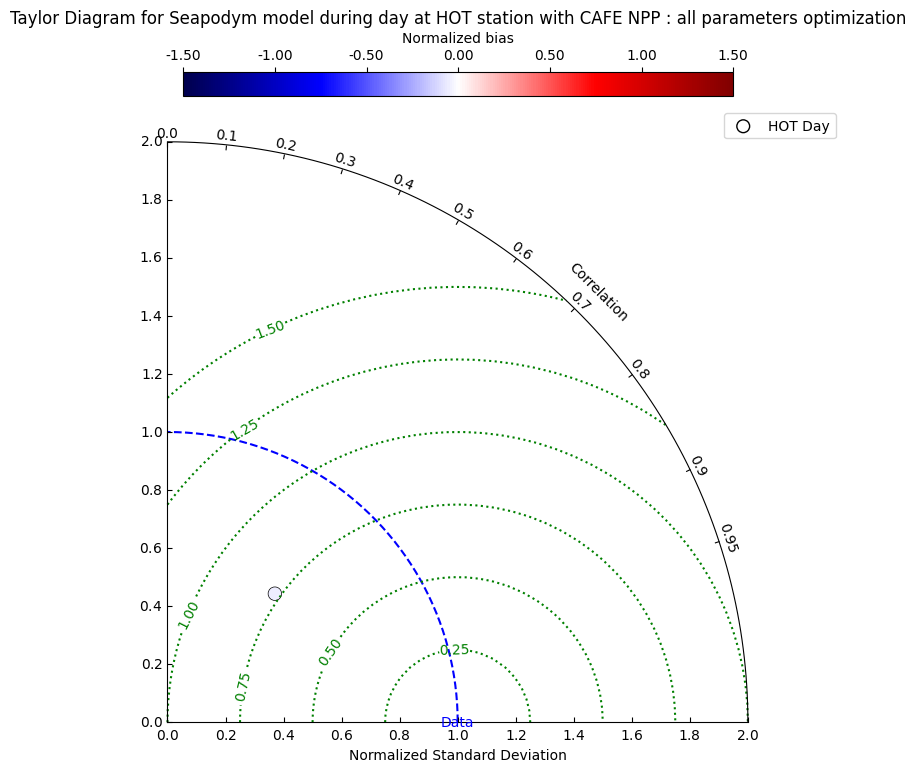

In [31]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred]
all_obs = [monthly_obs_day]

all_names = ["HOT Day"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title("Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [32]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.641206,0.577057,-0.050766,0.770046
